# Neural Graph Learning on politician relationships

## Introduction to the dataset

This dataset is about [House representatives of the 115th US congress](https://en.wikipedia.org/wiki/List_of_members_of_the_United_States_House_of_Representatives_in_the_115th_Congress_by_seniority). It contains 445 politicians/observations/vertices and the following attributes on each person:

- `WikiPageName` - Wikipedia page identifier
- `Party` - Party loyalty of the person
- `State` - State that the person represents
- `Sex` - Gender of the person
- `Age` - Age of the person

For the purposes of training neural networks on this data, features `State`, `Sex`, and `Age` have been onehot-encoded in a preprocessing notebook (link below) as these are input features for the network. `WikiPageName` is not included as it is unqiue for each person and thence not considered a trainable feature. Values in the target attribute `Party` are converted to scalars: 0=Democratic, 1=Republican.

Additionally, it contains 2773 relations/edges between the politicians. Two politicians are related if one of them has retweeted or tagged the other in a tweet on Twitter. An undirected graph is assumed, so if one tags the other, then the other has a reference to the one as well.

The dataset has been put together by collecting data from several sources. The main source is the github repository of files prepared and hosted by Technical University of Denmark Associate Professor Sune Lehmann Jørgensen for the 2018 installment of his DTU Compute course 02805 Social Graphs and Interactions. This repo contains a [list of members](https://github.com/suneman/socialgraphs2018/blob/master/files/data_US_congress/H115.csv) of the 115th House of representatives and a [zip-file](https://github.com/suneman/socialgraphs2018/blob/master/files/data_twitter/tweets.zip) of the 200 most recent tweets of said members (collected around September 2018). This data has been further preprocessed to extend the feature-set of the observations and more for the purposes of this project.

To see more about the dataset and preprocessing see the [preprocessing notebook](preprocessing_politician_relationship_data.ipynb) for the politician data.
 
Data summary:

- 445 vertices (politicians)
    - State (50-element onehot vector)
    - Sex (2-element onehot vector)
    - Age (54-element onehot vector)
- 2 labels:
    - Democratic (0)
    - Republican (1)
- 2773 edges (relations)


## Experiment

The goal is to correctly classify the party of politicians and examine the performance difference between the Neural Graph Learning model and a base model. Both are implemented with Tensorflow's NSL library and, by extension, Tensorflow's Keras API. 
To properly examine the performance difference between the models, each model is trainined with traning sizes from 0.1 to 0.85 with 0.05 incrementes. The models are run 5 times at each training size whereafter the results are avaraged and presented in a graph.

### PyTorch implementation of base model
To provide a control and reference point for the NSL base model that is evaluated in this notebook, a base model has been implemented with an independent neural network library - PyTorch. The achieved validation accuracy is at 68.7%, which is very close to that of the NSL model. It is therefore concluded that the NSL base model is credible.
Refer to the [PyTorch notebook](Pytorch-Base-Model.ipynb) for more information. 


## References

Large parts of the code for preprocessing, loading train, test and validation data, evaluation, generation of Keras functional models is modified code from Tensorflow's tutorials and resources introducing neural structed learning. The original code can be found here: [Tensorflows github](https://github.com/tensorflow/neural-structured-learning) and [Guide and Tutorials](https://www.tensorflow.org/neural_structured_learning/framework). Furthermore, additional information about the API is available [here](https://www.tensorflow.org/neural_structured_learning/api_docs/python/nsl).

# Experiment

## Importing needed libraries

In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals
import neural_structured_learning as nsl
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Resets notebook state
tf.keras.backend.clear_session()

## Defining hyperparameters

In [31]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 2 # 2 parties
    self.max_seq_length = 106 # onehot state = 50, onehot age = 54, onehot sex = 2, total = 106
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.5 # how much do we use the graph for regularization in the training
    self.num_neighbors = 1
    ### model architecture
    self.num_fc_units = [50, 50] # define number of neurons in each layer
    ### training parameters
    self.train_epochs = 100
    self.batch_size = 32
    self.dropout_rate = 0.5
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

## Load train and test data

In [32]:
def parse_example(example_proto):

    feature_spec = {
        'attributes':
            tf.io.FixedLenFeature([HPARAMS.max_seq_length],
                                tf.int64,
                                default_value=tf.constant(
                                    0,
                                    dtype=tf.int64,
                                    shape=[HPARAMS.max_seq_length])),
        'label':
          tf.io.FixedLenFeature((), tf.int64, default_value=-1),
    }
    # We also extract corresponding neighbor features in a similar manner to
  # the features above.
    for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format('NL_nbr_', i, 'attributes')
        nbr_weight_key = '{}{}{}'.format('NL_nbr_', i, '_weight')
        feature_spec[nbr_feature_key] = tf.io.FixedLenFeature(
            [HPARAMS.max_seq_length],
            tf.int64,
            default_value=tf.constant(
            0, dtype=tf.int64, shape=[HPARAMS.max_seq_length]))

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
    feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
        [1], tf.float32, default_value=tf.constant([0.0]))

    features = tf.io.parse_single_example(example_proto, feature_spec)

    labels = features.pop('label')
    return features, labels


def make_dataset(file_path, training=False):
     #Creates a `tf.data.TFRecordDataset`.

    dataset = tf.data.TFRecordDataset([file_path])
    if training:
        dataset = dataset.shuffle(10000)
    dataset = dataset.map(parse_example)
    dataset = dataset.batch(HPARAMS.batch_size)
    return dataset

## Functional base model

In [33]:
def functional_model(hparams):
    """Creates a functional API-based multi-layer perceptron model."""
    inputs = tf.keras.Input(shape=(hparams.max_seq_length,), dtype='int64', name='attributes')

  # casting one hot to floating point format.
    cur_layer = tf.keras.layers.Lambda(
      lambda x: tf.keras.backend.cast(x, tf.float32))(
          inputs)

    for num_units in hparams.num_fc_units:
        cur_layer = tf.keras.layers.Dense(num_units, activation='relu')(cur_layer)
        cur_layer = tf.keras.layers.Dropout(hparams.dropout_rate)(cur_layer)
        #cur_layer = tf.keras.layers.BatchNormalization()(cur_layer)

    # if we want to have 2 neurons in the output layer, then we must one-hot encode the targets and use softmax
    #outputs = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(cur_layer) # use sparse_categorical_crossentropy and accuracy
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(cur_layer)

    model = tf.keras.Model(inputs, outputs=outputs)
    return model

## Function to evaluate models

In [34]:
# Helper function to print evaluation metrics.
def print_metrics(model_desc, eval_metrics):
    print('\n')
    print('Eval accuracy for ', model_desc, ': ', eval_metrics['binary_accuracy']) # binary accuracy is used because we have two targets only: democratic and republican
#     print('Eval loss for ', model_desc, ': ', eval_metrics['loss'])
#     if 'graph_loss' in eval_metrics:
#         print('Eval graph loss for ', model_desc, ': ', eval_metrics['graph_loss'])

## Function for training base model

In [35]:
def traning_base_model(train_dataset):
    base_model = functional_model(HPARAMS)

    base_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
        lr=0.01, clipnorm=1.)
    base_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=0)
    
    return base_model

## Function for training graph model

In [36]:
def training_graph_model(train_dataset):
    # Build a new base MLP model.
    base_reg_model = functional_model(HPARAMS)
    
    # Wrap the base MLP model with graph regularization.
    graph_reg_config = nsl.configs.make_graph_reg_config(
        max_neighbors=HPARAMS.num_neighbors,
        multiplier=HPARAMS.graph_regularization_multiplier,
        distance_type=HPARAMS.distance_type,
        sum_over_axis=-1)
    graph_reg_model = nsl.keras.GraphRegularization(base_reg_model, graph_reg_config)
    
    graph_reg_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'])
    graph_reg_history = graph_reg_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=0)
    
    return graph_reg_model

## Function for generating data

In [37]:
def generateTrainingData(train_percent):
    # getting the training percentages
    !python3 preprocessing_pol_dataset_test.py \
    --input_content=H115_nodes_oh.tsv \
    --input_graph=H115_connections.tsv \
    --train_percentage=$train_percent\
    --output_train_data=train_merged_examples.tfr \
    --output_test_data=test_examples.tfr \

    # generating train and test data
    train_dataset = make_dataset('train_merged_examples.tfr', training=True)
    test_dataset = make_dataset('test_examples.tfr')
    
    return train_dataset, test_dataset

## Iterating over different training sizes

In [38]:
# defining the training size we need to iterate over
train_percentage = []
train_percentage.append(0.01) # starting the list at 1% of training data

for i in np.arange(0.05, 0.9, 0.05):
    train_percentage.append(round(i,2))

In [39]:
# lists for holding results
graph_accuracy_by_training_size_avg = []
base_accuracy_by_training_size_avg = []

for j in range(5):
    
    print("----------------------------- iteration: ", j+1, "------------------------" )
    base_model_results_list = []
    graph_model_results_list = []

    for i in range(len(train_percentage)):

        print("---------------------training at percentage ", train_percentage[i], "-----------------------------")

        # creating test and training data
        train_dataset, test_dataset = generateTrainingData(train_percentage[i])

        # creating and training the base model
        base_model = traning_base_model(train_dataset)

        # evaluate base model
        eval_results = dict(
        zip(base_model.metrics_names,
            base_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
        print_metrics('Base MLP model', eval_results)

        # adding results to a list
        base_model_results_list.append(eval_results)


        # creating and training the graph model
        graph_model = training_graph_model(train_dataset)

        # evaluating the model
        eval_results_graph_regulated_model = dict(
        zip(graph_model.metrics_names,
            graph_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
        print_metrics('MLP + graph regularization', eval_results_graph_regulated_model)

        # adding the graph results to a list 
        graph_model_results_list.append(eval_results_graph_regulated_model)

    graph_accuracy_by_training_size_avg.append(graph_model_results_list)
    base_accuracy_by_training_size_avg.append(base_model_results_list);

Output removed to improve readability of the notebook.

# Taking a look at the results
Since we ran 5 iterations we first have to average the numner training accuracy at the different training sizes.

In [40]:
graph_avg_list = []
base_avg_list = []

for i in range(0,len(graph_accuracy_by_training_size_avg[0])):
    tmp_avg_value = 0
    for j in range(0,len(graph_accuracy_by_training_size_avg)):
        tmp_avg_value += graph_accuracy_by_training_size_avg[j][i]['binary_accuracy']
    graph_avg_list.append(tmp_avg_value/5)
    
for i in range(0,len(base_accuracy_by_training_size_avg[0])):
    tmp_avg_value = 0
    for j in range(0,len(base_accuracy_by_training_size_avg)):
        tmp_avg_value += base_accuracy_by_training_size_avg[j][i]['binary_accuracy']
    base_avg_list.append(tmp_avg_value/5)

To get at better idea of the difference in learning at different training sizes we substract the two model preformances from each other.
A postive value indicates a gain for the graph based model over the base model.

In [41]:
diff_graph_and_basemodel = []

for i in range(len(base_avg_list)):
    diff_graph_and_basemodel.append(graph_avg_list[i]- base_avg_list[i])

collected_list = []
collected_list.append(base_avg_list)
collected_list.append(graph_avg_list)
collected_list.append(diff_graph_and_basemodel)

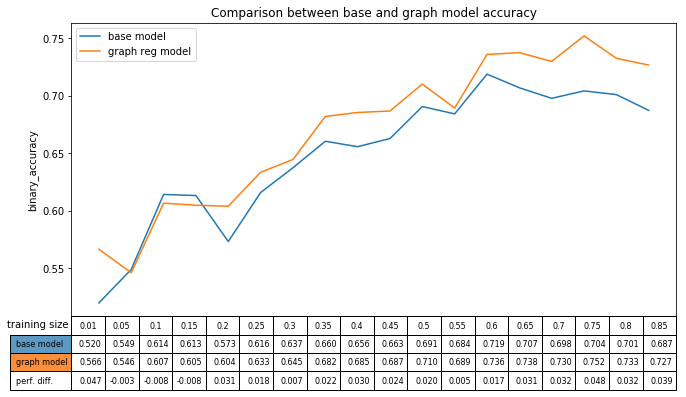

In [42]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

columns = train_percentage
rows = ['base model', 'graph model', 'perf. diff.']

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))

# Get some pastel shades for the colors
n_rows = len(collected_list)

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(train_percentage))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    y_offset = collected_list[row]
    cell_text.append(['%1.3f' % x for x in y_offset])

# Add a table at the bottom of the axes
table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      rowColours=['#5b9ac4', '#fd8e39', '#ffffff'],
                      loc='bottom')

table.set_fontsize(14)

# table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1.7)
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)


# plt.plot(graph_collected)
plt.plot(base_avg_list)
plt.plot(graph_avg_list)

# plt.ylabel("Loss in ${0}'s".format(value_increment))
# plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Comparison between base and graph model accuracy')
plt.ylabel('binary_accuracy')
# plt.xlabel('training size')
plt.annotate('training size', xy=(1,0), xytext=(-669, -3), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.legend(['base model', 'graph reg model'], loc='upper left')
plt.savefig('plots/comparison between base and graph model with different training sizes AVG w. table.png', bbox_inches='tight', pad_inches=0.1)

plt.show()